# MNIST Using CNN

In [9]:
import tensorflow as tf

In [10]:
from tensorflow.examples.tutorials.mnist import input_data

In [11]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [12]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [13]:
mnist.train.images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
mnist.train.num_examples

55000

In [15]:
mnist.test.num_examples

10000

In [16]:
mnist.validation.num_examples

5000

### Visualizing the Data

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
mnist.train.images[17].shape

(784,)

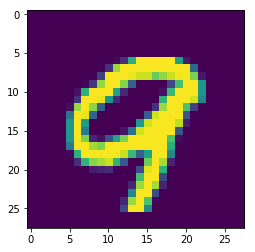

In [19]:
plt.imshow(mnist.train.images[17].reshape(28,28))

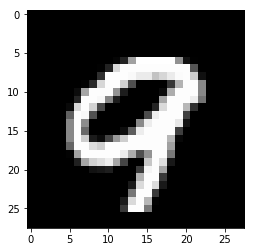

In [20]:
plt.imshow(mnist.train.images[17].reshape(28,28),cmap='gist_gray')

In [21]:
mnist.train.images[17].max()

1.0

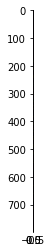

In [22]:
plt.imshow(mnist.train.images[17].reshape(784,1))

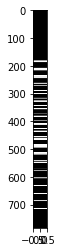

In [23]:
plt.imshow(mnist.train.images[17].reshape(784,1),cmap='gist_gray',aspect=0.02)

### Helper Functions

Function to help intialize random weights for fully connected or convolutional layers, we leave the shape attribute as a parameter for this.

In [34]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

Same as init_weights, but for the biases

In [35]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

Created a 2D convolution using builtin conv2d from TF. From those docs:

Computes a 2-D convolution given 4-D `input` and `filter` tensors.

Given an input tensor of shape `[batch, in_height, in_width, in_channels]`
and a filter / kernel tensor of shape
`[filter_height, filter_width, in_channels, out_channels]`, this op
performs the following:

1. Flattens the filter to a 2-D matrix with shape
   `[filter_height * filter_width * in_channels, output_channels]`.
2. Extracts image patches from the input tensor to form a *virtual*
   tensor of shape `[batch, out_height, out_width,
   filter_height * filter_width * in_channels]`.
3. For each patch, right-multiplies the filter matrix and the image patch
   vector.


In [36]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Created a max pooling layer, again using built in TF functions:

Performs the max pooling on the input.

    Args:
      value: A 4-D `Tensor` with shape `[batch, height, width, channels]` and
        type `tf.float32`.
      ksize: A list of ints that has length >= 4.  The size of the window for
        each dimension of the input tensor.
      strides: A list of ints that has length >= 4.  The stride of the sliding
        window for each dimension of the input tensor.
      padding: A string, either `'VALID'` or `'SAME'`. 

In [37]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

Using the conv2d function, we would return an actual convolutional layer here that uses an ReLu activation.

In [38]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

This is a normal fully connected layer

In [39]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

### Placeholders

In [40]:
x = tf.placeholder(tf.float32,shape=[None,784])

In [41]:
y_true = tf.placeholder(tf.float32,shape=[None,10])

### Layers

In [42]:
x_image = tf.reshape(x,[-1,28,28,1])

In [43]:
convo_1 = convolutional_layer(x_image,shape=[6,6,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [44]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [45]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [46]:
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [47]:
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function

In [48]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Optimizer

In [49]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
train = optimizer.minimize(cross_entropy)

### Intialize Variables

In [50]:
init = tf.global_variables_initializer()

### Session

In [21]:
steps = 5000

with tf.Session() as sess:
    
    sess.run(init)
    
    for i in range(steps):
        
        batch_x , batch_y = mnist.train.next_batch(50)
        
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:mnist.test.images,y_true:mnist.test.labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1368


Currently on step 100
Accuracy is:
0.8652


Currently on step 200
Accuracy is:
0.9095


Currently on step 300
Accuracy is:
0.9287


Currently on step 400
Accuracy is:
0.938


Currently on step 500
Accuracy is:
0.9471


Currently on step 600
Accuracy is:
0.9502


Currently on step 700
Accuracy is:
0.9554


Currently on step 800
Accuracy is:
0.9576


Currently on step 900
Accuracy is:
0.9606


Currently on step 1000
Accuracy is:
0.9633


Currently on step 1100
Accuracy is:
0.9657


Currently on step 1200
Accuracy is:
0.9657


Currently on step 1300
Accuracy is:
0.9678


Currently on step 1400
Accuracy is:
0.969


Currently on step 1500
Accuracy is:
0.9713


Currently on step 1600
Accuracy is:
0.9716


Currently on step 1700
Accuracy is:
0.9701


Currently on step 1800
Accuracy is:
0.9725


Currently on step 1900
Accuracy is:
0.9737


Currently on step 2000
Accuracy is:
0.9742


Currently on step 2100
Accuracy is:
0.9756


Currently on step 2200
A

## Our Model's Accuracy Rate is 98.4